In [1]:
import torch
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from auxillary.yolo_code_that_we_use import *
from tqdm.notebook import tqdm
from auxillary.confusion_matrix_class import ConfusionMatrix

from auxillary.mapping import HomographyMapping
#from AUC
from auxillary.detection import get_label,compare_post_process,evaluate_batch,table_analysis,load_dataset,set_im_and_label_paths_to_all
#from main
from auxillary.detection import load_detection_model,get_detection,helper_plot_bbox,plot_bboxes

import json
from roboflow import Roboflow
from pathlib import Path

cwd = Path.cwd()
%matplotlib inline

### Load dataset from Roboflow

In [9]:
dataset_name = Path('8-Ball-Pool-3')
# folder_type = 'train'
weight_path = Path('detection_model_weight/detection_model.pt')

if not dataset_name.exists():
    with open("roboflow.json", "r") as f:
        roboflow_api_key = json.load(f)
    rf = Roboflow(api_key=roboflow_api_key["ROBOFLOW_API_KEY"])
    project = rf.workspace("bachelorthesis").project("8-ball-pool-l530o")
    project.version(3).download("yolov5");

In [3]:
model, im_paths, label_paths = load_dataset(dataset_name, weight_path=weight_path)

Using cache found in C:\Users\jonas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-12 Python-3.11.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [7]:
save_folder = Path('plot_export/')
save_folder.mkdir(parents=True, exist_ok=True)

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


saved to plot_export\compare_post_procsess.png


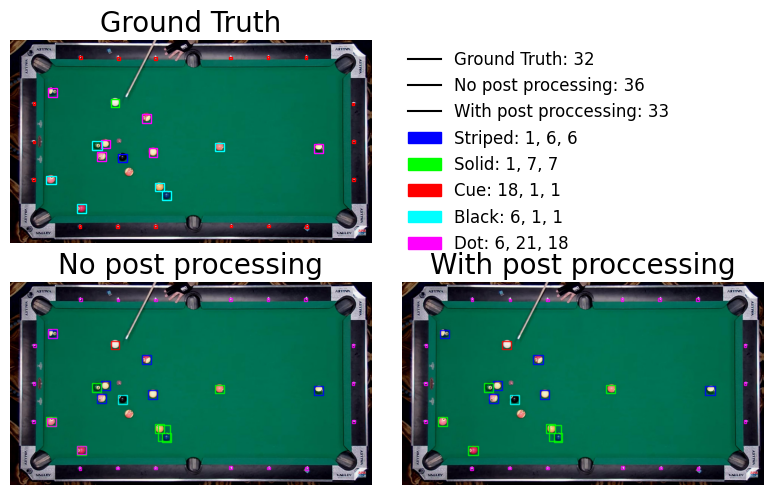

In [10]:
%matplotlib inline

img_id = 12
im = cv2.imread(str(im_paths[img_id]))[:,:,::-1]
im_size = im.shape[:2]
labels = get_label(label_paths[img_id], im_size)
_,detections = get_detection(im_paths[img_id], model, post_process=False, conf_thresh=0, iou_thresh=0,output_format='corner')
# detections = np.concatenate((detections[:,5:], detections[:,:4]), axis=1)
_,detections_post = get_detection(im_paths[img_id], model,output_format='corner')

compare_post_process(im, labels, detections, detections_post,save_path=save_folder / 'compare_post_procsess.png')


In [12]:
str(im_paths[4])

'8-Ball-Pool-3\\train\\images\\4_png.rf.e18166281030baded761bc4f93be6120.jpg'

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


saved to plot_export\plot_bboxes_4.png


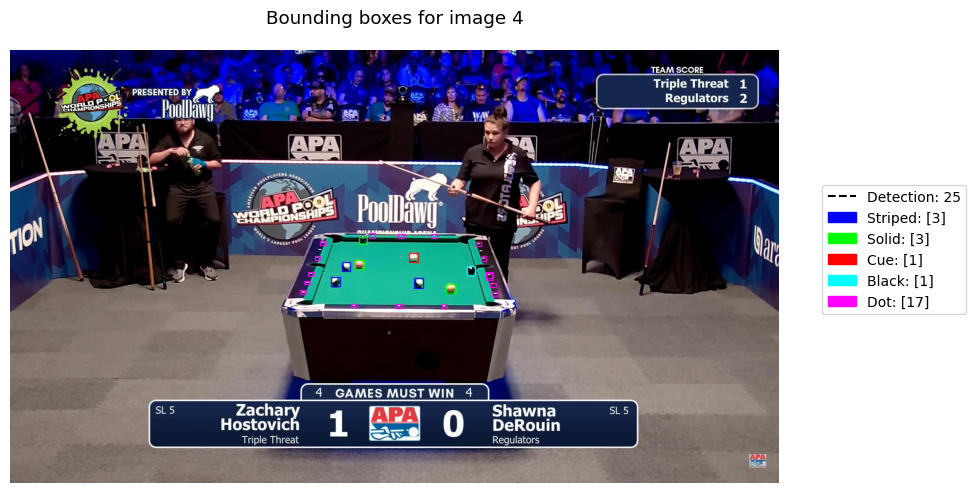

In [ ]:
%matplotlib inline

# Plot bounding boxes for each image in the folder
im_idxes = [4]
for im_idx in im_idxes:
    im = cv2.imread(str(im_paths[im_idx]))[:,:,::-1]
    im_size = im.shape[:2]
    
    _,detections = get_detection(im_paths[im_idx], model, post_process=True)
    labels = None
    
    im_number = im_paths[im_idx].name.split('_')[0]
    classes_to_plot=['Striped', 'Solid', 'Cue', 'Black', 'Dot']
    plot_bboxes(im, labels, detections, im_idx= im_number, legend=True,save_path=save_folder / f'plot_bboxes_{im_number}.png')

## Main

Load model and get detection from images in a folder. These will function as the states for the RL environment.

In [7]:
save_folder = Path('plot_export/')
save_folder.mkdir(parents=True, exist_ok=True)

In [3]:
datanum = 0
im_path = '8-Ball-Pool-3/train/images/54_png.rf.18d8023ac7bcdc316c9be6efbd0070ef.jpg'
# im_path = '8-Ball-Pool-3/train/images/194_png.rf.6b3c01d7e039ffa56fe5023410954781.jpg'
model_path = 'detection_model_weight/detection_model.pt'

detection_model = load_detection_model(model_path)

Using cache found in C:\Users\jonas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-12 Python-3.11.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


saved to plot_export\plot_bboxes_0.png


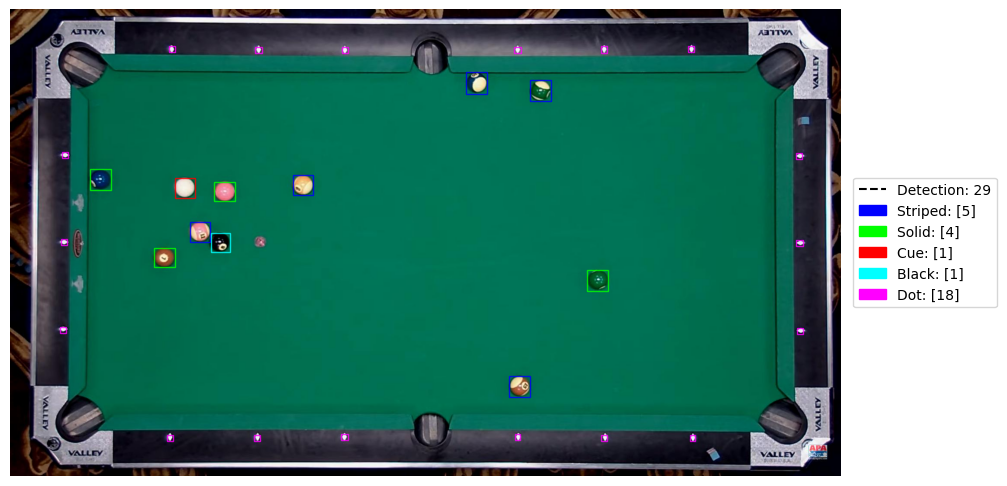

In [4]:
%matplotlib inline

image, detections = get_detection(im_path=im_path, model=detection_model, post_process=True)
plot_bboxes(image, None, detections,save_path=save_folder / f'plot_bboxes_{datanum}.png')

image_as_cv2 = cv2.imread(im_path)[:,:,::-1] # TODO: fix this to work with image directly

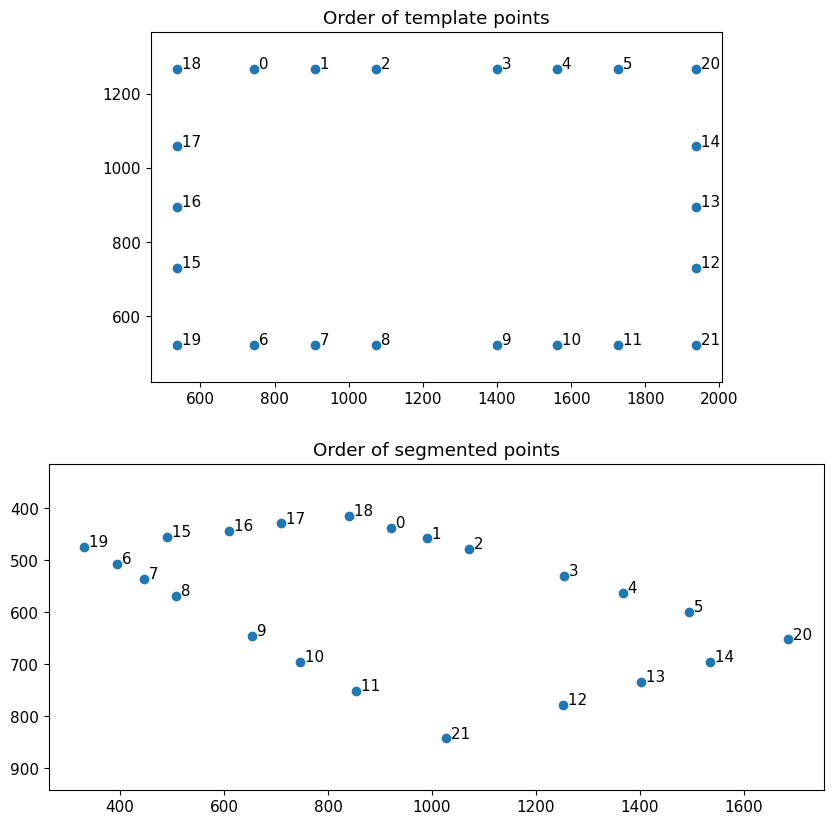

In [74]:
%matplotlib inline
# Use HomographyMapping to extract lines and convert to RL environment format

label = 't' # used for saving files only
thres = 3

dots_newformat = detections[detections[:, 5]==4]
balls_newformat = detections[detections[:, 5]!=4]

Object = HomographyMapping(label,dots_newformat[:,0:2],thres,image_as_cv2,balls_newformat,datanum,save_folder)
Object.extract_lines()

# Object.plot_lines(save=True)
Object.plot_template(save=True)

# extract results from topview image
H, template_points, found_points, ball_H, dist_error, viewtype, warpedim = Object.extract_things_we_might_need()

In [6]:
rl_balls = Object.to_RL()

In [7]:
rl_balls

array([[    0.62016,     0.86774,           1],
       [    0.21938,     0.36741,           2],
       [    0.72568,     0.59531,           2],
       [    0.16501,     0.35754,           3],
       [    0.56179,    0.086805,           1],
       [    0.18586,     0.47169,           1],
       [     0.1377,     0.53792,           2],
       [    0.32619,     0.35052,           1],
       [   0.050163,     0.33603,           2],
       [    0.64816,      0.1073,           1],
       [    0.21346,     0.49953,           4]])

In [20]:
np.save('rl_balls', rl_balls)

### Compare 2 images

In [8]:
im_path_t = '8-Ball-Pool-3/train/images/1t_png.rf.4e6421a849d36687701eb5b4187ff417.jpg'
im_path_a = '8-Ball-Pool-3/train/images/1a_png.rf.17bf9820312efff2213b1d1b08ffad66.jpg'

In [9]:
_, detections_t = get_detection(im_path=im_path_t, model=detection_model, post_process=True)
image_as_cv2_t = cv2.imread(im_path_t)[:,:,::-1] # TODO: fix this to work with image directly

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Error in dot count, using only corners for mapping


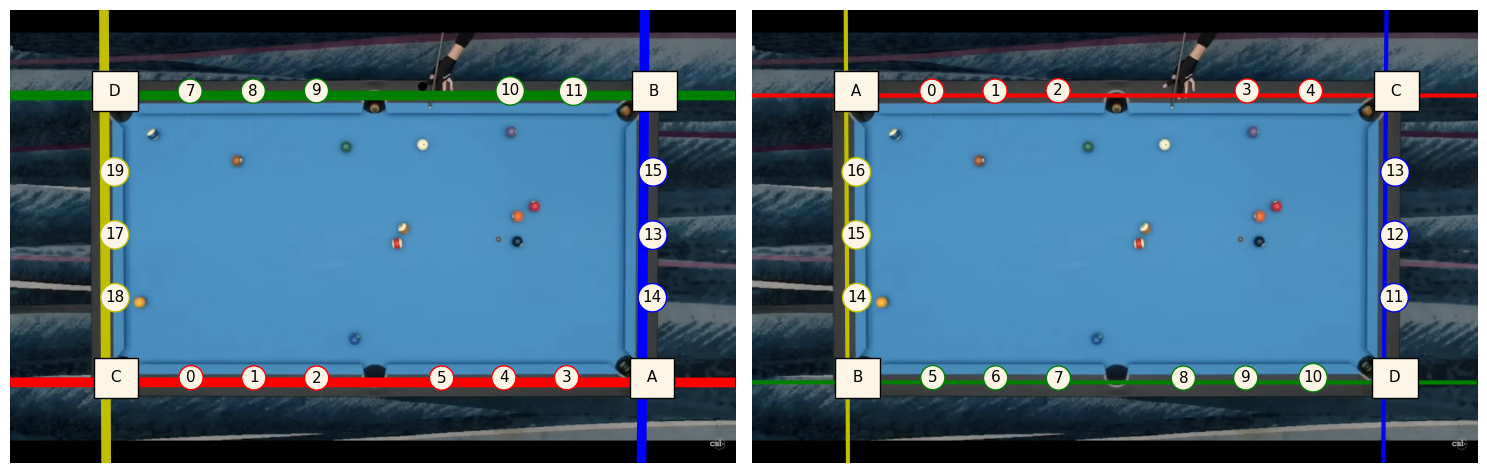

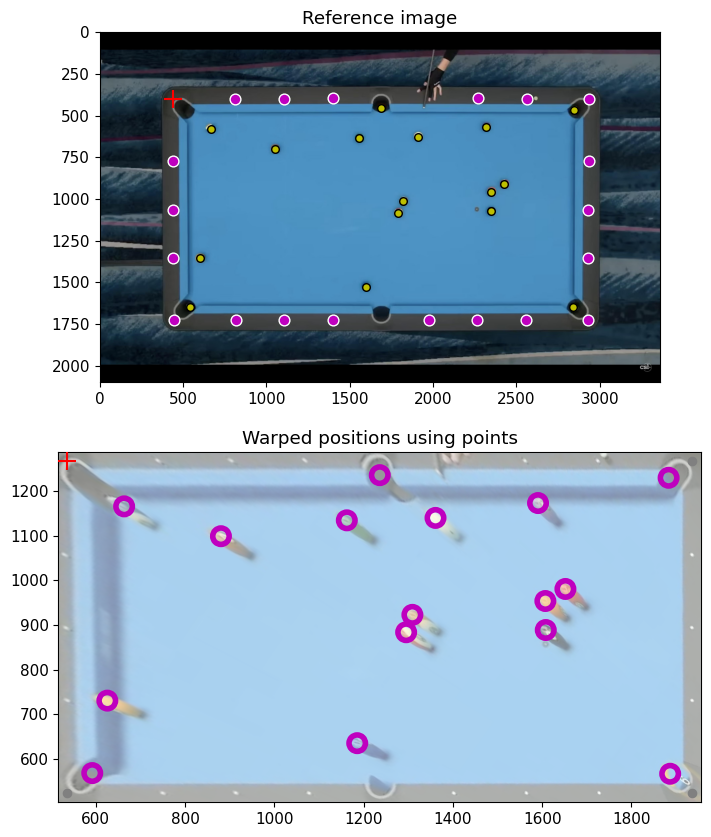

In [10]:
%matplotlib inline
# Use HomographyMapping to extract lines and convert to RL environment format

label = 't' # used for saving files only
thres = 3

dots_newformat = detections[detections[:, 5]==4]
balls_newformat = detections[detections[:, 5]!=4]

Object_t = HomographyMapping(label,
                           detections_t[detections_t[:, 5]==4][:, 0:2],
                           thres,
                           image_as_cv2_t,
                           detections_t[detections_t[:, 5]!=4][:,0:2],
                           datanum,
                           save_folder)
Object_t.extract_lines()

Object_t.plot_lines(save=True)
# Object.plot_template(save=True)

# extract results from topview image
# H, template_points, found_points, ball_H, dist_error, viewtype, warpedim = Object.extract_things_we_might_need()
Object_t.plot_compare2topview(compareballs=ball_H, warpedim=warpedim)

In [24]:
ball_H.shape, balls_newformat.shape

((12, 2), (12, 6))

In [26]:
balls_newformat[:, -1]

array([          1,           1,           1,           1,           2,           3,           1,           1,           1,           0,           0,           0])

In [32]:
template_points, found_points

(array([[ 536, 1267],
        [ 536,  523],
        [1936, 1267],
        [1936,  523]]),
 array([[     1319.8,      779.59],
        [      242.9,       933.9],
        [     3017.8,      1383.6],
        [     1625.9,      1869.3]]))

In [30]:
np.hstack((ball_H, balls_newformat[:, -1][:, None]))

array([[     1181.5,      1117.3,           1],
       [     1211.4,      621.11,           1],
       [     1626.2,      938.06,           1],
       [     1669.8,      963.65,           1],
       [     1379.8,      1122.5,           2],
       [     1626.3,      872.94,           3],
       [     1608.9,      1155.9,           1],
       [     901.83,      1082.7,           1],
       [      654.9,      717.36,           1],
       [     1332.4,      908.07,           0],
       [     1314.7,         870,           0],
       [     687.55,      1147.4,           0]])

### POOL ENV

In [2]:
import gymnasium as gym

from auxillary.RL_Pool_env3 import PoolEnv
from auxillary.RL_config_env import *
from auxillary.RL_functions import run_model, load_RL_model

from auxillary.RL_custom_evaluate_policy import custom_evaluate_policy
from auxillary.RL_custom_evaluate_policy import custom_evaluate_policy_masked

from stable_baselines3 import PPO, TD3, A2C, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env

from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO

In [13]:
# Setup
ALGO = "PPO"  # PPO_masked  TD3  PPO  SAC DDPG A2C
ORACLE = False  # Enable Oracle if true
nb = 16  # Number of balls.

# Load learned states
assert nb == 1 or nb == 2 or nb == 16
if nb == 2: ls = np.load("1_000_000_states.npy")
elif nb == 16: ls = np.load("1_000_000_states_full_table.npy")
else: ls = None

# ls = np.load('rl_balls.npy')
ls = Object.to_RL()
# Try with image above
# ls = detections[detections[:, -1] != 4][:, [0, 1, -1]]  # Get only ball detections and keep only x,y and class values

env_kwargs = dict(
    algo=ALGO,
    balls_init=ls,
    suit=2,
    training=False,
    fps=60,  # 60
    num_balls=nb,
    special_state=None,  # 497852  666
    obs_type='vector',
    sigma=0,
    oracle=ORACLE,
    game_type='normal',  # 'blue_only' or 'normal'
    bank_shots=False,
    max_num_shots=1
)

use_masking = True if ALGO == 'PPO_masked' else False

In [93]:
ls

array([[    0.91349,     0.82529,           2],
       [    0.83132,     0.58016,           2],
       [    0.56994,     0.66394,           4],
       [    0.74994,     0.75684,           2],
       [    0.95073,     0.69762,           1],
       [    0.80486,     0.47664,           1],
       [    0.35188,     0.81344,           3],
       [    0.45742,     0.21167,           2],
       [    0.49728,     0.91241,           1],
       [    0.72753,     0.11447,           1],
       [    0.29338,     0.20453,           1],
       [    0.10724,     0.51995,           2],
       [    0.08266,     0.26193,           1],
       [    0.58231,     0.10514,           2],
       [    0.62534,     0.17635,           2]])

In [14]:
RL_model, env = load_RL_model(ALGO, env_kwargs)
run_model(RL_model, env, max_steps=100, render=True, use_masking=use_masking)

Using PPO algorithm
------------------------------



--------------------------------------------------
Action                    Angle:   15.59
                          Force:  500.00

- reward off
hit_suit                  10.00 
hit_suit                  10.00 
- reward off
target_angle_pocket       -25.82 with spec:  31.36 
--------------------------------------------------
Total Reward              -5.82
Total Reward (normalized):    -0.0277
--------------------------------------------------

0.0%



--------------------------------------------------
Action                    Angle:   15.59
                          Force:  500.00

- reward off
hit_suit                  10.00 
hit_suit                  10.00 
- reward off
target_angle_pocket       -25.82 with spec:  31.36 
--------------------------------------------------
Total Reward              -5.82
Total Reward (normalized):    -0.0277
--------------------------------------------------




---------------------------------

SystemExit: 

### Combine RL with images

In [4]:
from stable_baselines3 import PPO, TD3, A2C, DDPG, SAC

In [3]:
def get_observation(state):
    
    obs = np.array([[ball[0], ball[1], ball[2]/4] for ball in state])

    balls_to_fill = 16 - len(obs)
    if len(obs) == 0:
        # if no balls on table
        obs = (np.repeat(np.array([0, 0, 0]), balls_to_fill, axis=0).reshape(balls_to_fill, 3).flatten())
    elif balls_to_fill > 0:
        # if some balls are pocketed
        obs = np.vstack((obs,
                            np.repeat(np.array([0, 0, 0]), balls_to_fill, axis=0).reshape(balls_to_fill, 3),)
                        ).flatten()
    else:
        obs = obs.flatten()

    return obs

def get_action(model, state):
    obs = get_observation(state)
    action, _states = model.predict(obs, deterministic=True)
    angle, force = action
    angle = angle / 100 - 180
    force = force / 29
    return np.array([angle, force])


def load_RL_no_env(model_path):
    algo = model_path.split('/')[-1].split('.')[0]
    if algo == 'PPO': model = PPO.load(model_path)
    elif algo == 'TD3': model = TD3.load(model_path)
    elif algo == 'DDPG': model = DDPG.load(model_path)
    elif algo == 'SAC': model = SAC.load(model_path)
    elif algo == 'A2C': model = A2C.load(model_path)
    elif algo == 'PPO_masked': model = MaskablePPO.load(model_path)
    return model


In [4]:
datanum = 0
im_path = '8-Ball-Pool-3/train/images/180_png.rf.d95ed08408ababb588c6d1af919a1ba5.jpg'
# im_path = '8-Ball-Pool-3/train/images/194_png.rf.6b3c01d7e039ffa56fe5023410954781.jpg'
detection_model_path = 'detection_model_weight/detection_model.pt'
RL_model_path = 'RL_models/PPO.zip'


In [5]:
detection_model = load_detection_model(detection_model_path)
RL_model = load_RL_no_env(RL_model_path)

%matplotlib inline

Using cache found in C:\Users\jonas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-12 Python-3.11.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


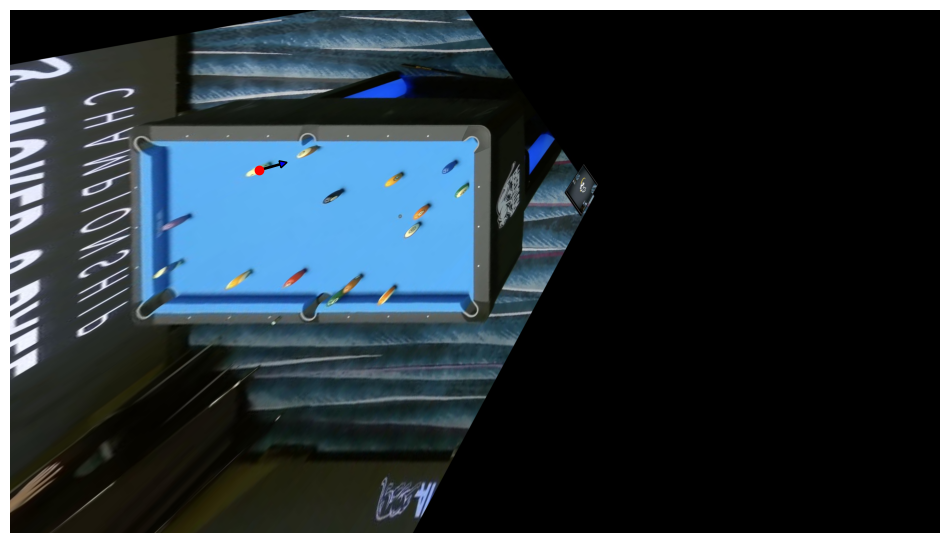

In [8]:
_, detections = get_detection(im_path=im_path, model=detection_model, post_process=True)
image = cv2.imread(im_path)[:,:,::-1] # TODO: fix this to work with image directly

label = 't' # used for saving files only
thres = 3

dots_newformat = detections[detections[:, 5]==4]
balls_newformat = detections[detections[:, 5]!=4]

Object = HomographyMapping(label,dots_newformat[:,0:2],thres,image,balls_newformat,datanum,save_folder)
Object.extract_lines()

ball_H = Object.ball_H
image = Object.warpedim

state = Object.to_RL()
angle, force = get_action(RL_model, state)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.imshow(image)
ax.axis('off')

cue_ball = ball_H[balls_newformat[:, -1] == 2, :4].flatten()[:2]
max_length = 100  # pxels
length = force * max_length
angle_rad = np.deg2rad(angle)

dx = length * np.cos(angle_rad)
dy = -length * np.sin(angle_rad)

ax.plot(*cue_ball, 'ro')
ax.arrow(*cue_ball, dx, dy, width=5, head_width=30, head_length=30, fc='blue', ec='black')

# Optional: axis settings
ax.set_xlim(0, image.shape[1])
ax.set_ylim(image.shape[0], 0)  # flip y-axis to match image coordinates
ax.set_aspect('equal')
plt.show()

In [40]:
angle, force

(np.float64(166.5), np.float64(1.0))

In [ ]:
cue_ball = balls_newformat[balls_newformat[:, -1] == 2, :4].flatten()[:2]
cue_ball

array([     403.84,      412.87])

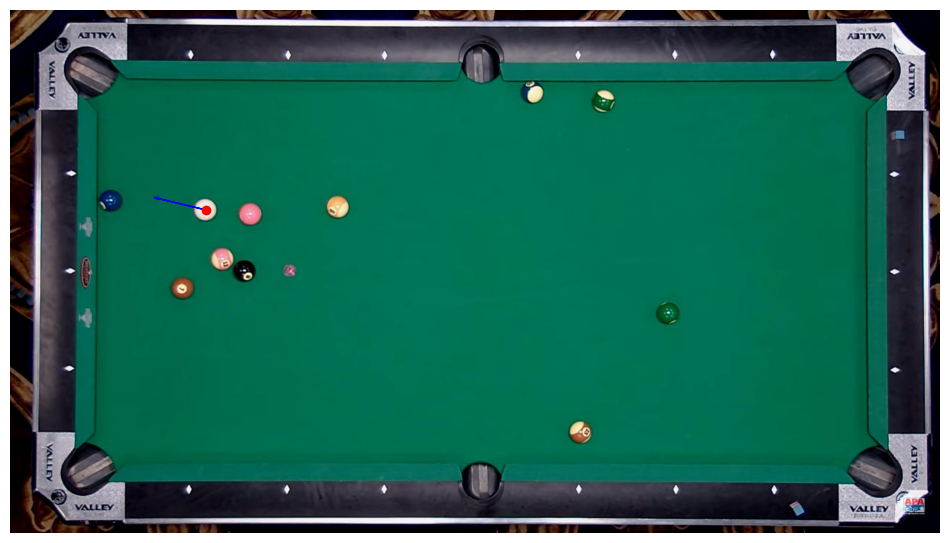

#### Ignore

In [21]:
def mask_fn(env: gym.Env) -> np.ndarray:
    # Do whatever you'd like in this function to return the action mask
    # for the current env. In this example, we assume the env has a
    # helpful method we can rely on.
    return env.valid_action_mask()


if __name__ == "__main__":
    # Settings
    obs_type = "vector"
    LOG = False
    TRAINING = False
    CHEAT = False
    timesteps = 1_200_000
    n_envs = 1

    # save_path = 'final_tests'
    nb = 16
    ALGO = "PPO_masked"  # PPO_masked  TD3  PPO  SAC DDPG A2C
    LOAD_MODEL = True

    assert nb == 1 or nb == 2 or nb == 16
    if nb == 2: ls = np.load("1_000_000_states.npy")
    elif nb == 16: ls = np.load("1_000_000_states_full_table.npy")
    else: ls = None
    
    env_kwargs = dict(
        algo=ALGO,
        balls_init=ls,
        suit=2,
        training=TRAINING,
        fps=60,  # 60
        num_balls=nb,
        special_state=None,  # 497852  666
        obs_type=obs_type,
        sigma=0,
        cheat_force=CHEAT,
        cheat_angle=CHEAT,
        game_type='normal',  # 'blue_only' or 'normal'
        bank_shots=False
    )
    env = make_vec_env(PoolEnv, seed=1, n_envs=n_envs, env_kwargs=env_kwargs)
    print(f"LOAD_MODEL: {LOAD_MODEL}")
    if ALGO != "PPO_masked":
        model_path = f"RL_models/{ALGO}.zip"
        if ALGO == "PPO":
            if LOAD_MODEL: model = PPO.load(model_path, env)
            else: model = PPO(policy='MlpPolicy', env=env)
        elif ALGO == "TD3":
            if LOAD_MODEL: model = TD3.load(model_path, env)
            else: model = TD3(policy='MlpPolicy', env=env)
        elif ALGO == "A2C":
            if LOAD_MODEL: model = A2C.load(model_path, env)
            else: model = A2C(policy='MlpPolicy', env=env)
        elif ALGO == "SAC":
            if LOAD_MODEL: model = SAC.load(model_path, env=env)
            else: model = SAC(model_path, env)
        elif ALGO == "DDPG":
            if LOAD_MODEL: model = DDPG.load(model_path, env=env)
            else: model = DDPG(model_path, env)

        # results = run_model(model, env, 1000, render=False)
        mean_reward, std_reward, sr, er = custom_evaluate_policy(
            model, env, n_eval_episodes=500, warn=False)

    else:
        env = PoolEnv(**env_kwargs)         # Initialize environment
        env = ActionMasker(env, mask_fn)    # Wrap to enable masking

        # policy_kwargs = dict(activation_fn=torch.nn.ReLU,
        #                      net_arch=dict(pi=[400, 300], vf=[400, 300]))

        model_kwargs = dict(
            policy=MaskableActorCriticPolicy,
            env=env,
            batch_size=256,
            # learning_rate=lr_schedule_linear(3e-4),
            # policy_kwargs=policy_kwargs,
            n_steps=2048,
            verbose=1
            # device='cuda'
        )

        model_path = f"RL_models/{ALGO}.zip"
        model2 = MaskablePPO.load(model_path, env)

        mean_reward, std_reward, sr, er = custom_evaluate_policy_masked(
            model2, env, n_eval_episodes=500, warn=False)


Using PPO_masked algorithm
------------------------------
LOAD_MODEL: True
Using PPO_masked algorithm
------------------------------
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.



--------------------------------------------------
Action                    Angle:  171.92
                          Force:  314.14

- reward off
pocketed_suit             50.00 with spec: ball 12 
first_hit_none            -7.36 with spec:  0.15 
- reward off
target_angle_pocket       41.58 with spec:  0.92 
--------------------------------------------------
Total Reward              84.22
Total Reward (normalized):     0.4011
--------------------------------------------------




--------------------------------------------------
Action                    Angle: -102.15
                          Force:  381.72

- reward off
- reward off
hit_suit                  10.00 
- reward off
target_angle_pocket       7.33 with spec:  7.44 
--------------------------------------------

SystemExit: 